# Clasification on VIET AI Dataset

The dataset includes 3,285 images from Cao Thang Eye Hospital (CTEH) (3210 abnormal and 75 normals) and 500 normal images from Messidor and EYEPACS dataset. We will use 3,435 images for training and predict diseases on 350 unlabeled images.

Diseases Covered by dataset are:
diabetic retinopathy, Opacity, Glaucoma, Macular edema, Macular degeneration, Retinal vascular occlusion. 
We consider diabetic retinopathy, glaucoma macular degeneration along with normal images. 


# Import Files & Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, CategoricalHinge
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [ ]:
import datetime
from tensorboard.plugins.hparams import api as hp

In [ ]:
train=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/viet_ai_dataset/train.csv")
test=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/viet_ai_dataset/sample_submission.csv")

# Import Data

In [ ]:
train

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
3430,315991e4e5d3.jpg,0,0,0,0,0,0,1
3431,46ff848f59d4.jpg,0,0,0,0,0,0,1
3432,2477323c9434.jpg,0,0,0,0,0,0,1
3433,0a1ca36be2c5.jpg,0,0,0,0,0,0,1


In [ ]:
test

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0
...,...,...
345,c3d744001f2f.jpg,0 0
346,f7b9fdd3d7e1.jpg,0 0
347,937b3f57bea7.jpg,0 0
348,4caffcaefb29.jpg,0 0


# EDA + Conversion to multi - class problem

In [ ]:
sum_column = train['normal']+train['diabetic retinopathy']+train['macular degeneration']+train['glaucoma']

In [ ]:
# No of images making problem multi label
index_multi_labeled=[]

for i in range(0,len(sum_column)):
  if (sum_column[i]!=1):
    index_multi_labeled.append(i)
print(len(index_multi_labeled))
print(index_multi_labeled)

1138
[0, 1, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 26, 27, 29, 38, 39, 40, 41, 44, 45, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 68, 69, 75, 80, 81, 90, 91, 92, 93, 97, 98, 103, 104, 111, 112, 113, 114, 115, 116, 117, 118, 119, 131, 132, 133, 135, 136, 137, 140, 141, 142, 143, 144, 146, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 171, 172, 173, 174, 175, 176, 177, 178, 183, 184, 185, 190, 191, 194, 195, 200, 201, 202, 203, 204, 207, 208, 209, 210, 224, 225, 226, 227, 235, 237, 238, 242, 244, 245, 246, 247, 258, 259, 260, 261, 264, 272, 274, 275, 276, 278, 280, 281, 282, 290, 291, 294, 295, 303, 304, 312, 313, 320, 321, 322, 323, 326, 327, 335, 336, 337, 338, 339, 341, 342, 347, 348, 349, 350, 351, 352, 353, 369, 370, 371, 373, 374, 375, 376, 377, 384, 388, 392, 398, 402, 404, 407, 414, 415, 426, 427, 428, 430, 431, 432, 433, 434, 463, 464, 465, 466, 467, 468, 469, 480, 481, 482, 483, 484, 496, 505, 506, 507, 508, 509, 510, 514, 515, 516, 517, 518, 519, 520, 521, 522

In [ ]:
train=train.drop(['macular edema','retinal vascular occlusion','opacity'],axis=1)

# drop multi labeled images
train.drop(index_multi_labeled,inplace=True)

In [ ]:
train

,filename,diabetic retinopathy,glaucoma,macular degeneration,normal
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,1,0
4,0def470360e4.jpg,0,0,1,0
12,802b4bfabd52.jpg,0,0,1,0
18,10ee8c8a72b4.jpg,1,0,0,0
...,...,...,...,...,...
3430,315991e4e5d3.jpg,0,0,0,1
3431,46ff848f59d4.jpg,0,0,0,1
3432,2477323c9434.jpg,0,0,0,1
3433,0a1ca36be2c5.jpg,0,0,0,1


In [ ]:
LABELS = train.columns[1:]
def build_label(row):
  return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
train.apply(lambda x: build_label(x), axis=1).value_counts()

print(LABELS)

def build_label_list(row):
  return [LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1]
        
train["label"] = train.apply(lambda x: build_label_list(x), axis=1)

Index(['diabetic retinopathy', 'glaucoma', 'macular degeneration', 'normal'], dtype='object')


In [ ]:
train

,filename,diabetic retinopathy,glaucoma,macular degeneration,normal,label
2,3f58d128caf6.jpg,0,1,0,0,[glaucoma]
3,4ce6599e7b20.jpg,0,0,1,0,[macular degeneration]
4,0def470360e4.jpg,0,0,1,0,[macular degeneration]
12,802b4bfabd52.jpg,0,0,1,0,[macular degeneration]
18,10ee8c8a72b4.jpg,1,0,0,0,[diabetic retinopathy]
...,...,...,...,...,...,...
3430,315991e4e5d3.jpg,0,0,0,1,[normal]
3431,46ff848f59d4.jpg,0,0,0,1,[normal]
3432,2477323c9434.jpg,0,0,0,1,[normal]
3433,0a1ca36be2c5.jpg,0,0,0,1,[normal]


No of images in each class

In [ ]:
train.sum()

filename                3f58d128caf6.jpg4ce6599e7b20.jpg0def470360e4.j...
diabetic retinopathy                                                  727
glaucoma                                                              529
macular degeneration                                                  516
normal                                                                525
label                   [glaucoma, macular degeneration, macular degen...
dtype: object

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,validation_split=0.1,
    horizontal_flip=True,preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/viet_ai_dataset/train",
    batch_size=32,color_mode="rgb",subset='training',
    x_col='filename',class_mode='categorical',target_size=(224, 224),y_col='label')

    #    shuffle=True,

Found 2068 validated image filenames belonging to 4 classes.


In [ ]:
validation_generator= train_datagen.flow_from_dataframe(
    train,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/viet_ai_dataset/train",
    batch_size=32,color_mode="rgb",subset='validation',
    x_col='filename',class_mode='categorical',target_size=(224, 224),y_col='label')
    #shuffle=True,

Found 229 validated image filenames belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(test,directory="/content/gdrive/My Drive/Colab Notebooks/Derbi Hackathon/viet_ai_dataset/test",
                                                  x_col='filename',
                                                  batch_size=32,target_size=(224, 224),class_mode=None)

Found 350 validated image filenames.


# ResNet50 Model

In [ ]:
batch_size = 32
image_size= 229

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

base_model = ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer

x = GlobalAveragePooling2D()(x)

#Dropout Layer
#x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.summary()

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=base_learning_rate), loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
# Callbacks
#Save best model
ckpt_filename= "/content/gdrive/My Drive/Colab Notebooks/VietAI_resnet50_class_weights_final.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, mode='min', verbose = 1)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=15,callbacks=[checkpoint, early_stop, lr_reduce])

Epoch 1/15
65/65 [==============================] - 516s 8s/step - loss: 1.5390 - accuracy: 0.2321 - val_loss: 1.3640 - val_accuracy: 0.4541

Epoch 00001: val_loss improved from inf to 1.36400, saving model to /content/gdrive/My Drive/Colab Notebooks/VietAI_resnet50_class_weights_final.hdf5
Epoch 2/15
65/65 [==============================] - 377s 6s/step - loss: 1.4845 - accuracy: 0.2761 - val_loss: 1.3624 - val_accuracy: 0.4541

Epoch 00002: val_loss improved from 1.36400 to 1.36242, saving model to /content/gdrive/My Drive/Colab Notebooks/VietAI_resnet50_class_weights_final.hdf5
Epoch 3/15
65/65 [==============================] - 376s 6s/step - loss: 1.4831 - accuracy: 0.2539 - val_loss: 1.3931 - val_accuracy: 0.4279

Epoch 00003: val_loss did not improve from 1.36242
Epoch 4/15
65/65 [==============================] - 381s 6s/step - loss: 1.4602 - accuracy: 0.2684 - val_loss: 1.3783 - val_accuracy: 0.4541

Epoch 00004: val_loss did not improve from 1.36242
Epoch 5/15
65/65 [========

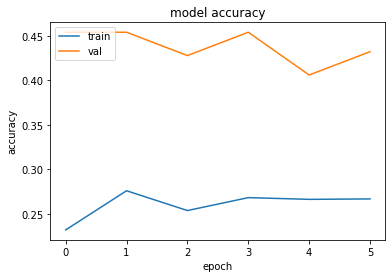

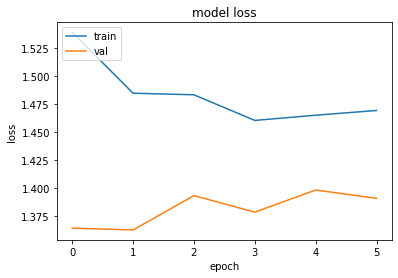

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

plot_acc(history)
plt.show()
plot_loss(history)
plt.show()

In [ ]:
#Load the best model during initial training
model.load_weights(ckpt_filename)

In [ ]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_generator)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

11/11 [==============================] - 61s 6s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss on test set:  0.0
Accuracy on test set:  0.0


## Fine tuning

In [ ]:
#Finetuning - Unfreeze the last layers of the model
base_model.trainable = True

In [ ]:
# Callbacks & Checkpoint
final_ckpt_filename= "/content/gdrive/My Drive/Colab Notebooks/VietAI_post_finetuning_resnet50_class_weights.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose = 1)

model.compile(optimizer=Adam(learning_rate=base_learning_rate), loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
history_unfreeze = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint, early_stop, lr_reduce])

Epoch 1/15
65/65 [==============================] - 1447s 22s/step - loss: 0.6943 - accuracy: 0.7200 - val_loss: 5.8608 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 5.86080, saving model to /content/gdrive/My Drive/Colab Notebooks/VietAI_post_finetuning_resnet50_class_weights.hdf5
Epoch 2/15
65/65 [==============================] - 1500s 23s/step - loss: 0.3769 - accuracy: 0.8583 - val_loss: 9.5848 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 5.86080

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 3/15
65/65 [==============================] - 1464s 23s/step - loss: 0.2623 - accuracy: 0.9028 - val_loss: 9.4590 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 5.86080

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-09.
Epoch 00003: early stopping


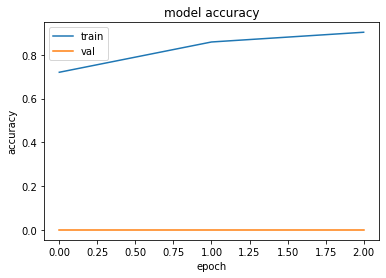

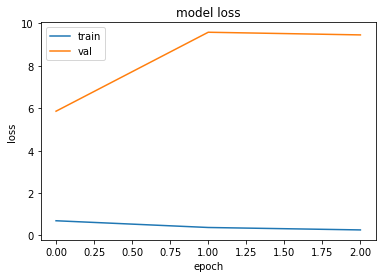

In [ ]:
def plot_loss(history_unfreeze):
    plt.plot(history_unfreeze.history['loss'])
    plt.plot(history_unfreeze.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history_unfreeze):
    plt.plot(history_unfreeze.history['accuracy'])
    plt.plot(history_unfreeze.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

plot_acc(history_unfreeze)
plt.show()
plot_loss(history_unfreeze)
plt.show()

# Efficient Net B0 Model

In [ ]:
IMG_SHAPE = (224, 224,3)

base_model=EfficientNetB0(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x=Flatten()(x)

predictions = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=base_learning_rate), loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
ckpt_filename= "/content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_VietAI_EfficientNetB0_Multiclass_v2.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose = 1)

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=15, callbacks=[checkpoint,early_stop,lr_reduce]) 

Epoch 1/15
65/65 [==============================] - 145s 2s/step - loss: 1.5656 - accuracy: 0.2621 - val_loss: 1.6394 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.63935, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_VietAI_EfficientNetB0_Multiclass_v2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
65/65 [==============================] - 137s 2s/step - loss: 1.4438 - accuracy: 0.2693 - val_loss: 1.7704 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.63935
Epoch 3/15
65/65 [==============================] - 136s 2s/step - loss: 1.4701 - accuracy: 0.2698 - val_loss: 1.4731 - val_accuracy: 0.2271

Epoch 00003: val_loss improved from 1.63935 to 1.47308, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_VietAI_EfficientNetB0_Multiclass_v2.hdf5
Epoch 4/15
65/65 [==============================] - 135s 2s/step - loss: 1.4453 - accuracy: 0.2573 - val_loss: 1.2865 - val_accuracy: 0.3188

Epoch 00004: val_loss improved from 1.47308 to 1.28647, saving model to /content/gdrive/My Drive/Colab Notebooks/DerbiHackathon_VietAI_EfficientNetB0_Multiclass_v2.hdf5
Epoch 5/15
65/65 [==============================] - 135s 2s/step - loss: 1.4599 - accuracy: 0.2466 - val_loss: 1.3183 - val_accuracy: 0.3188

Epoch 00005: val_loss did not improve f

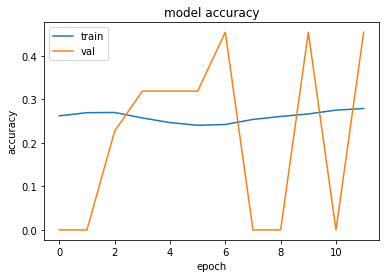

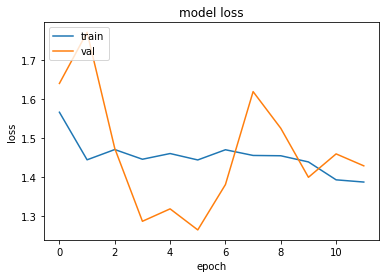

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

plot_acc(history)
plt.show()
plot_loss(history)
plt.show()